In [7]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import os
import warnings
warnings.filterwarnings("ignore", category=UserWarning, message="Geometry is in a geographic CRS.*")
warnings.simplefilter(action="ignore", category=pd.errors.SettingWithCopyWarning)

# Load in hybrid boundary stats

In [50]:
def merge_hybrid(shp_path, hybrid_stats_path):
    """
    Merges hybrid boundary shapefile with hybrid statistics.
    
    Parameters:
    shp_path (str): Path to the hybrid boundary shapefile.
    hybrid_stats_path (str): Path to the hybrid statistics CSV file.
    
    Returns:
    gpd.GeoDataFrame: Merged GeoDataFrame containing hybrid boundaries and statistics.
    """
    hybrid = gpd.read_file(shp_path)
    hybrid_stats = pd.read_csv(hybrid_stats_path)
    
    stats = hybrid_stats[['Admin 2', 'Year', 'Area Harvested: ha', 'Yield: MT/ha', 'Quantity Produced: MT', 'Source crop']]
    stats.columns = ["name_state", "year", "area_harvested", "yield", "production", "ag_hy_crop"]
    
    merged_hybrid = stats.merge(hybrid, how='left')
    merged_hybrid = gpd.GeoDataFrame(merged_hybrid, geometry='geometry')
    
    return hybrid, merged_hybrid

In [55]:
shp_path = "../shapefiles/2016_2023_hybrid_boundary_071925.shp" 
hybrid_stats_path = "../../data/temporally_harmonized_crop_data_072425.csv"

In [56]:
hybrid, merged_hybrid = merge_hybrid(shp_path, hybrid_stats_path)


# Load in ICRISAT product

In [57]:
# Load in the 1966 boundaries with names matched to ICRISAT data
icri_path = "../shapefiles/icrisat_apportioned/icrisat_boundary_match.shp"
icri = gpd.read_file(icri_path)

In [58]:
if hybrid.crs != icri.crs:
    icri = icri.to_crs(hybrid.crs)

colname1 = "name"
colname2 = "Dist_Name"

hybrid['name'] = hybrid[colname1]
icri['name'] = icri[colname2]

In [59]:
icri

,NAME_0,ID_0,ISO,ID_1,NAME_1,ID_2,NAME_2,TYPE_2,ENGTYPE_2,NL_NAME_2,...,JNAME_1,JVARNAME_2,JNAME_1a,JNAME_2,Name_12,Code,Shape_Leng,Shape_Area,geometry,name
0,India,105,IND,2,Andhra Pradesh,3,Anantapur,District,District,None,...,Andhra Pradesh,"Anantpur, Ananthapur",Andhra Pradesh,Anantapur,Ananthapur,52,11.941762,1.611876,"POLYGON ((77.69 15.17628, 77.69378 15.17347, 7...",Ananthapur
1,India,105,IND,2,Andhra Pradesh,4,Chittoor,District,District,None,...,Andhra Pradesh,Chitoor|Chittor,Andhra Pradesh,Chittoor,Chittoor,54,10.154083,1.266210,"POLYGON ((78.47611 13.9368, 78.48208 13.93007,...",Chittoor
2,India,105,IND,2,Andhra Pradesh,5,Cuddapah,District,District,None,...,Andhra Pradesh,None,Andhra Pradesh,Cuddapah,Kadapa YSR,53,6.682595,1.269949,"POLYGON ((78.94612 15.19465, 78.95062 15.18535...",Kadapa YSR
3,India,105,IND,2,Andhra Pradesh,6,East Godavari,District,District,None,...,Andhra Pradesh,None,Andhra Pradesh,East Godavari,East Godavari,46,8.411279,0.913507,"MULTIPOLYGON (((82.31735 16.57653, 82.31735 16...",East Godavari
4,India,105,IND,2,Andhra Pradesh,7,Guntur,District,District,None,...,Andhra Pradesh,None,Andhra Pradesh,Guntur,Guntur,49,6.955453,0.964803,"MULTIPOLYGON (((80.78291 15.83764, 80.78291 15...",Guntur
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,India,105,IND,36,West Bengal,588,Murshidabad,District,District,None,...,West Bengal,None,West Bengal,Murshidabad,Murshidabad,804,5.073042,0.478267,"MULTIPOLYGON (((88.67597 24.3155, 88.67482 24....",Murshidabad
306,India,105,IND,36,West Bengal,589,Nadia,District,District,None,...,West Bengal,None,West Bengal,Nadia,Nadia,803,5.442187,0.345079,"POLYGON ((88.72438 24.07719, 88.72382 24.07345...",Nadia
307,India,105,IND,36,West Bengal,590,24 Paraganas,District,District,None,...,West Bengal,None,West Bengal,24 Paraganas,24 Parganas,800,40.780417,0.993566,"MULTIPOLYGON (((88.01861 21.57278, 88.01889 21...",24 Parganas
308,India,105,IND,36,West Bengal,591,Puruliya,District,District,None,...,West Bengal,None,West Bengal,Puruliya,Purulia,817,5.147798,0.552180,"POLYGON ((85.88916 23.15176, 85.88641 23.15335...",Purulia


<Axes: >

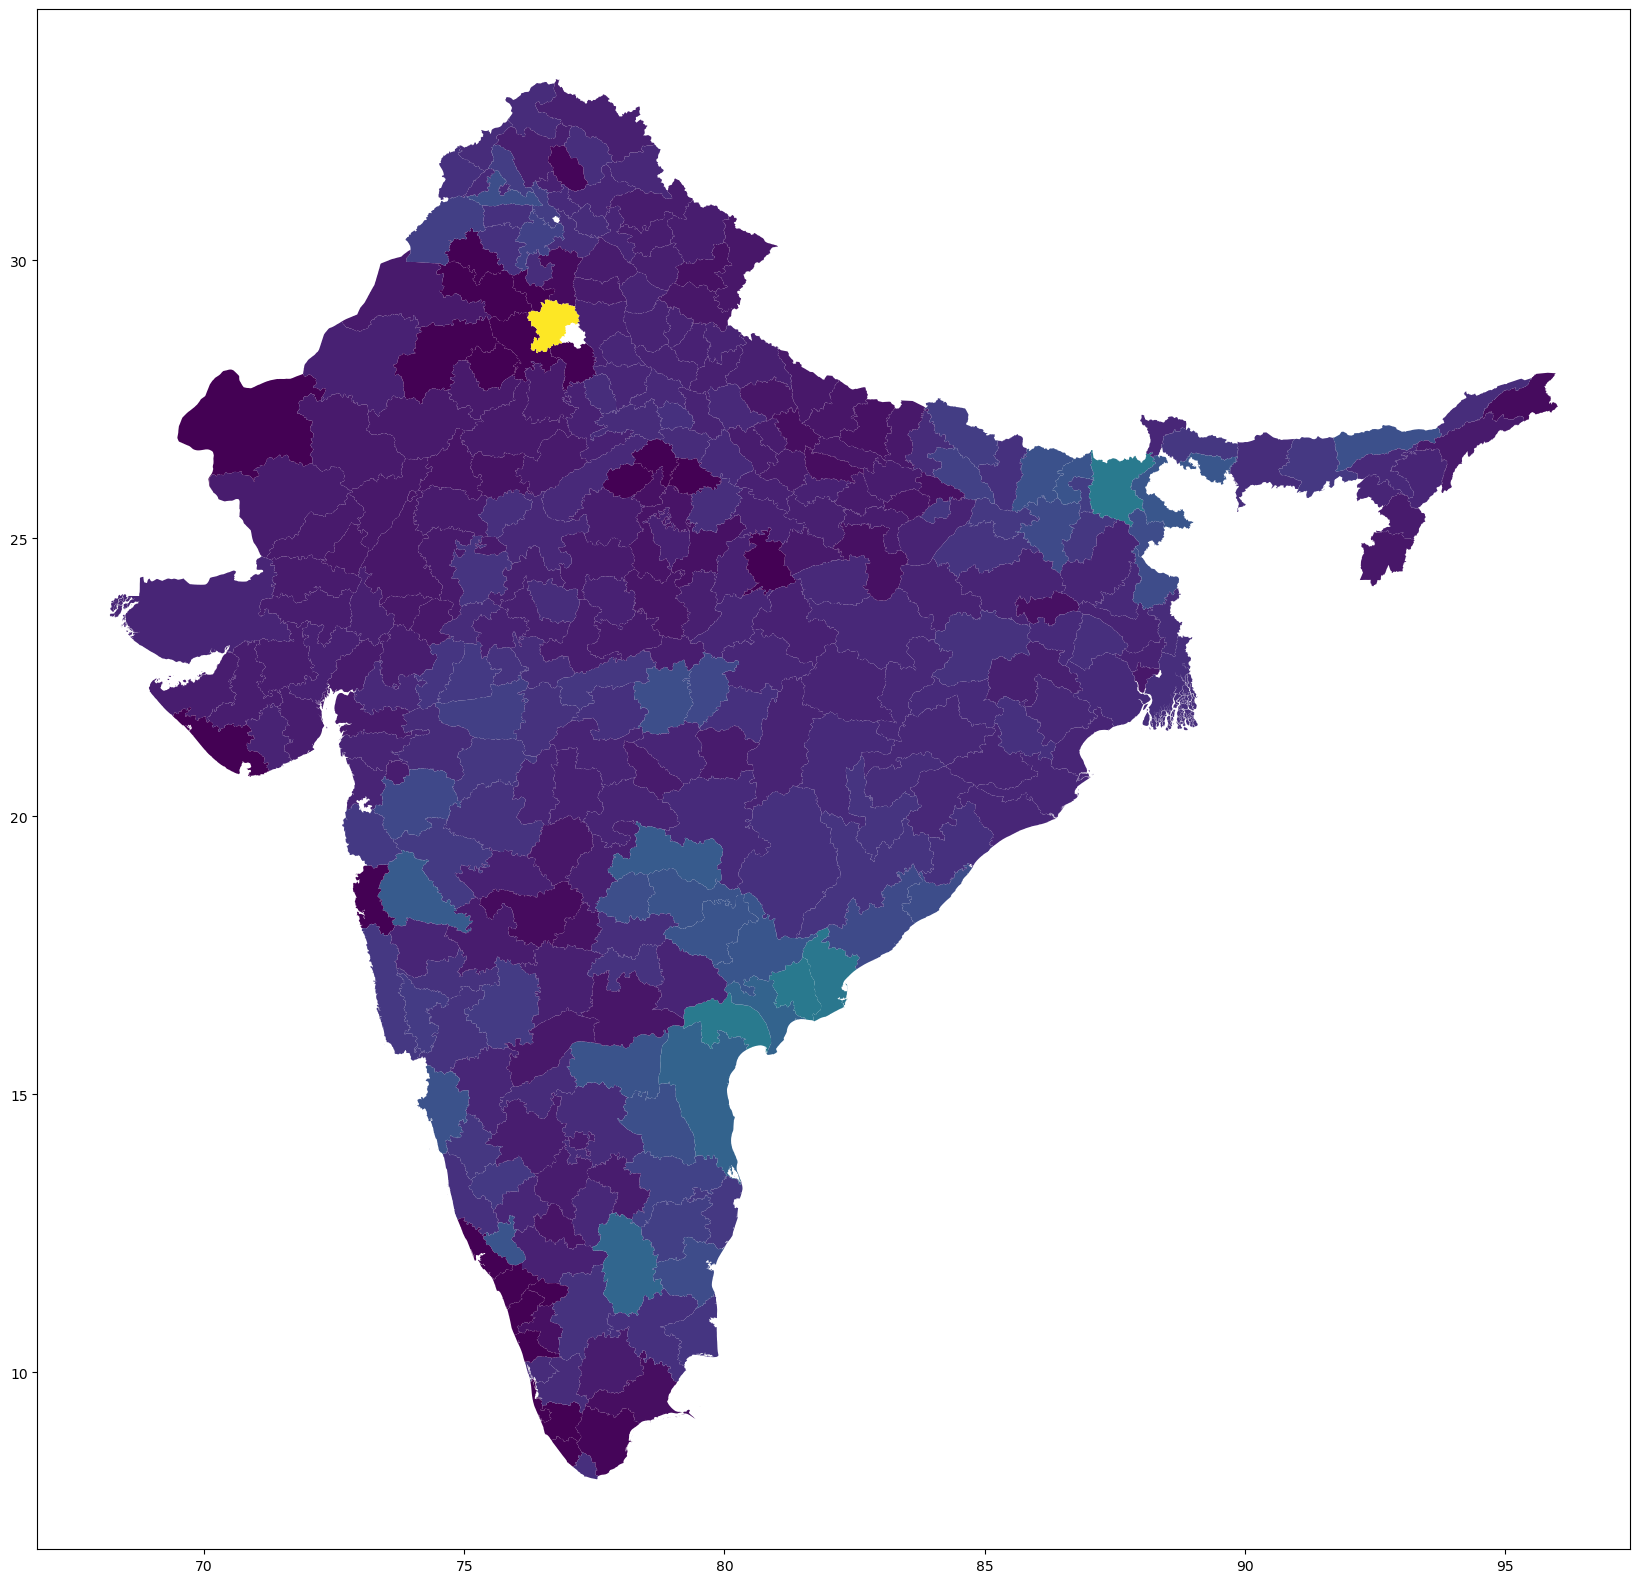

In [60]:
#Load in the ICRISAT apportioned data
icri_apportioned_path = '../shapefiles/icrisat_apportioned/ICRISAT-District Level Data_Apportioned.csv'
df = pd.read_csv(icri_apportioned_path)
icri = icri.rename(columns={'Name_12': 'Dist Name', 'NAME_1' : 'State Name'})
icri.loc[icri['State Name']== "Uttaranchal", "State Name"] = "Uttar Pradesh"
merged_icri = gpd.GeoDataFrame(icri.merge(df, how="left", on=['Dist Name', 'State Name']))

fig, ax = plt.subplots(figsize=(30, 20))
merged_icri[merged_icri['Year']==2016].plot(ax=ax, column="MAIZE YIELD (Kg per ha)")

# Great - let's now check to see continuity of the ICRISAT data for our main crops of interest at the national level (total national production/area harvested)

In [61]:
merged_icri.columns

Index(['NAME_0', 'ID_0', 'ISO', 'ID_1', 'State Name', 'ID_2', 'NAME_2',
       'TYPE_2', 'ENGTYPE_2', 'NL_NAME_2',
       ...
       'SUGARCANE YIELD (Kg per ha)', 'COTTON AREA (1000 ha)',
       'COTTON PRODUCTION (1000 tons)', 'COTTON YIELD (Kg per ha)',
       'FRUITS AREA (1000 ha)', 'VEGETABLES AREA (1000 ha)',
       'FRUITS AND VEGETABLES AREA (1000 ha)', 'POTATOES AREA (1000 ha)',
       'ONION AREA (1000 ha)', 'FODDER AREA (1000 ha)'],
      dtype='object', length=107)

In [62]:
# Determine the headings and units for each crop
import re
import pandas as pd
from collections import defaultdict

def parse_agricultural_columns(df):
    """
    Parse agricultural dataframe columns into a structured lookup table.
    
    Returns a nested dictionary: {crop: {metric_type: {column_name, units}}}
    """
    
    # Initialize the nested structure
    crop_lookup = defaultdict(lambda: defaultdict(dict))
    
    # Regex pattern to parse: "CROP_NAME METRIC_TYPE (units)"
    pattern = r'^(.+?)\s+(AREA|PRODUCTION|YIELD)\s*\((.+?)\)$'
    
    for column in df.columns:
        match = re.match(pattern, column, re.IGNORECASE)
        
        if match:
            crop_name = match.group(1).strip()
            metric_type = match.group(2).upper()
            units = match.group(3).strip()
            
            crop_lookup[crop_name][metric_type] = {
                'column_name': column,
                'units': units
            }
    
    return dict(crop_lookup)

In [63]:
class CropDataAccessor:
    def __init__(self, dataframe, crop_lookup):
        self.df = dataframe
        self.lookup = crop_lookup
        self.base_columns = ['State Name', 'Dist_Name', 'Year', 'geometry']
        
        # Check if we're working with a GeoPandas DataFrame
        self.is_geodf = isinstance(dataframe, gpd.GeoDataFrame)
    
    def _filter_by_years(self, year_min, year_max):
        """Private helper method for year filtering"""
        if year_min is None and year_max is None:
            return self.df
        
        if year_min is None:
            filtered = self.df[self.df['Year'] <= year_max]
        elif year_max is None:
            filtered = self.df[self.df['Year'] >= year_min]
        else:
            filtered = self.df[(self.df['Year'] >= year_min) & (self.df['Year'] <= year_max)]
        
        # Ensure we maintain GeoPandas structure
        if self.is_geodf and not isinstance(filtered, gpd.GeoDataFrame):
            filtered = gpd.GeoDataFrame(filtered, geometry='geometry', crs=self.df.crs)
        
        return filtered
    
    def _safe_column_selection(self, dataframe, columns):
        """Safely select columns while preserving GeoPandas structure"""
        # Remove duplicates while preserving order
        columns = list(dict.fromkeys(columns))
        
        # Select only columns that exist
        existing_columns = [col for col in columns if col in dataframe.columns]
        
        if self.is_geodf:
            # For GeoPandas, use .loc to maintain structure
            result = dataframe.loc[:, existing_columns]
            
            # Ensure geometry column is set correctly
            if 'geometry' in existing_columns and hasattr(result, 'geometry'):
                if not isinstance(result, gpd.GeoDataFrame):
                    result = gpd.GeoDataFrame(result, geometry='geometry', crs=self.df.crs)
                # Make sure geometry column is active
                result = result.set_geometry('geometry')
            
            return result
        else:
            # Regular pandas DataFrame
            return dataframe[existing_columns]
    
    def _get_crop_data(self, crop_name, metric_type, year_min=None, year_max=None, 
                       additional_columns=None, default=None):
        """Generic method for getting crop data"""
        # Check if crop and metric exist
        if crop_name not in self.lookup or metric_type not in self.lookup[crop_name]:
            return default
        
        # Get the column name
        column = self.lookup[crop_name][metric_type]['column_name']
        
        # Filter by years
        filtered_df = self._filter_by_years(year_min, year_max)
        
        # Build column list
        columns_to_select = self.base_columns.copy()
        columns_to_select.append(column)
        
        # Add any additional columns requested
        if additional_columns:
            if isinstance(additional_columns, str):
                additional_columns = [additional_columns]
            columns_to_select.extend(additional_columns)
        
        # Use safe column selection to preserve GeoPandas structure
        return self._safe_column_selection(filtered_df, columns_to_select)
    
    # All your other methods remain the same...
    def get_crop_area(self, crop_name, year_min=None, year_max=None, 
                      additional_columns=None, default=None):
        """Get area data for a specific crop"""
        return self._get_crop_data(crop_name, 'AREA', year_min, year_max, 
                                   additional_columns, default)
    
    def get_crop_production(self, crop_name, year_min=None, year_max=None, 
                            additional_columns=None, default=None):
        """Get production data for a specific crop"""
        return self._get_crop_data(crop_name, 'PRODUCTION', year_min, year_max, 
                                   additional_columns, default)
    
    def get_crop_area(self, crop_name, year_min=None, year_max=None, 
                      additional_columns=None, default=None):
        """Get area data for a specific crop"""
        return self._get_crop_data(crop_name, 'AREA', year_min, year_max, 
                                   additional_columns, default)
    
    def get_crop_production(self, crop_name, year_min=None, year_max=None, 
                            additional_columns=None, default=None):
        """Get production data for a specific crop"""
        return self._get_crop_data(crop_name, 'PRODUCTION', year_min, year_max, 
                                   additional_columns, default)
    
    def get_crop_yield(self, crop_name, year_min=None, year_max=None, 
                       additional_columns=None, default=None):
        """Get yield data for a specific crop"""
        return self._get_crop_data(crop_name, 'YIELD', year_min, year_max, 
                                   additional_columns, default)
    
    def get_all_crop_data(self, crop_name, year_min=None, year_max=None, 
                          additional_columns=None, default=None):
        """Get all available metrics for a crop in one dataframe"""
        if crop_name not in self.lookup:
            return default
        
        # Start with base data
        filtered_df = self._filter_by_years(year_min, year_max)
        result_columns = self.base_columns.copy()

        # Add all available metric columns for this crop
        for metric_type, metric_info in self.lookup[crop_name].items():
            column_name = metric_info['column_name']
            if column_name in filtered_df.columns:
                result_columns.append(column_name)
        
        # Add additional columns if requested
        if additional_columns:
            if isinstance(additional_columns, str):
                additional_columns = [additional_columns]
            result_columns.extend(additional_columns)
        
        # Remove duplicates and select existing columns
        result_columns = list(dict.fromkeys(result_columns))
        existing_columns = [col for col in result_columns if col in filtered_df.columns]
        
        return filtered_df[existing_columns]
    
    def get_crop_metrics(self, crop_name):
        """Get all available metrics for a crop"""
        return self.lookup.get(crop_name, {})
    
    def list_crops(self):
        """List all available crops"""
        return list(self.lookup.keys())
    
    def get_available_years(self):
        """Get the range of years available in the dataset"""
        if 'Year' in self.df.columns:
            
            return self.df['Year'].min(), self.df['Year'].max()
        return None, None

In [64]:
#Parses all of the crop data columns in the dataframe
crop_data = parse_agricultural_columns(merged_icri)

# Initialize the accessor
accessor = CropDataAccessor(merged_icri, crop_data)

accessor.get_crop_metrics('COTTON')['AREA']['column_name']
# Usage examples
# Just the basics
cotton_area = accessor.get_crop_area('COTTON', 2010, 2020)
cotton_production = accessor.get_crop_production('COTTON', 2010, 2020)

# Get all metrics for a crop at once
all_cotton = accessor.get_all_crop_data('COTTON', 2015, 2020)

# Check available years
min_year, max_year = accessor.get_available_years()

<Axes: >

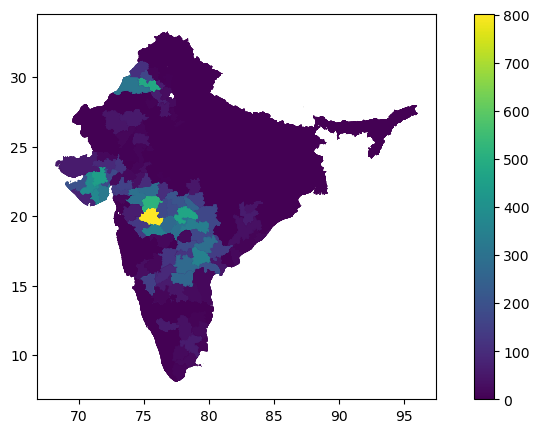

In [65]:
fig, ax = plt.subplots(figsize=(10, 5))
cotton_area.plot(ax=ax, column="COTTON AREA (1000 ha)", legend=True, cmap='viridis')

# Sanity Check About Zeros

Need to confirm that no rows have zeros in only one or two columns. If any column is zero, it should be zero in all columns for that row.

In [66]:
def validate_uniform_row_status(df, columns):
    """Validate that each row is either all zeros or all non-zeros"""
    subset = df[columns]
    
    # Check each row: either all zeros OR all non-zeros
    all_zeros = (subset == 0).all(axis=1)
    all_nonzeros = (subset != 0).all(axis=1)
    
    # Each row should satisfy exactly one of these conditions
    valid_rows = all_zeros | all_nonzeros
    
    return valid_rows.all()

In [67]:
results = {}
for crop in accessor.list_crops():
    print(f"Crop: {crop}")
    crop_data = accessor.get_all_crop_data(crop, 1966, 2017)

    columns_to_check = crop_data.columns[4:] # Skip the first four columns (State Name, Dist_Name, Year, geometry)
    results[crop] = validate_uniform_row_status(crop_data, columns_to_check)


Crop: RICE
Crop: WHEAT
Crop: KHARIF SORGHUM
Crop: RABI SORGHUM
Crop: SORGHUM
Crop: PEARL MILLET
Crop: MAIZE
Crop: FINGER MILLET
Crop: BARLEY
Crop: CHICKPEA
Crop: PIGEONPEA
Crop: MINOR PULSES
Crop: GROUNDNUT
Crop: SESAMUM
Crop: RAPESEED AND MUSTARD
Crop: SAFFLOWER
Crop: CASTOR
Crop: LINSEED
Crop: SUNFLOWER
Crop: SOYABEAN
Crop: OILSEEDS
Crop: SUGARCANE
Crop: COTTON
Crop: FRUITS
Crop: VEGETABLES
Crop: FRUITS AND VEGETABLES
Crop: POTATOES
Crop: ONION
Crop: FODDER


In [68]:
merged_icri

,NAME_0,ID_0,ISO,ID_1,State Name,ID_2,NAME_2,TYPE_2,ENGTYPE_2,NL_NAME_2,...,SUGARCANE YIELD (Kg per ha),COTTON AREA (1000 ha),COTTON PRODUCTION (1000 tons),COTTON YIELD (Kg per ha),FRUITS AREA (1000 ha),VEGETABLES AREA (1000 ha),FRUITS AND VEGETABLES AREA (1000 ha),POTATOES AREA (1000 ha),ONION AREA (1000 ha),FODDER AREA (1000 ha)
0,India,105,IND,2,Andhra Pradesh,3,Anantapur,District,District,None,...,8500.00,42.0,2.0,47.62,9.41,2.25,11.66,0.00,1.24,1.15
1,India,105,IND,2,Andhra Pradesh,3,Anantapur,District,District,None,...,7886.36,35.0,1.0,28.57,9.18,2.22,11.40,0.00,1.15,0.58
2,India,105,IND,2,Andhra Pradesh,3,Anantapur,District,District,None,...,7655.74,31.5,1.0,31.75,9.69,2.46,12.15,0.00,1.59,0.80
3,India,105,IND,2,Andhra Pradesh,3,Anantapur,District,District,None,...,7423.73,33.6,1.6,47.62,10.15,2.78,12.92,0.00,1.85,0.97
4,India,105,IND,2,Andhra Pradesh,3,Anantapur,District,District,None,...,6159.09,31.0,1.3,41.94,9.59,2.72,12.31,0.00,1.79,1.35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16093,India,105,IND,36,West Bengal,594,Midnapore,District,District,None,...,22062.30,0.0,0.0,0.00,21.65,166.88,188.52,65.05,0.00,0.00
16094,India,105,IND,36,West Bengal,594,Midnapore,District,District,None,...,17986.33,0.0,0.0,0.00,21.75,169.21,190.97,66.36,0.00,0.00
16095,India,105,IND,36,West Bengal,594,Midnapore,District,District,None,...,7472.22,0.0,0.0,0.00,21.86,191.83,213.69,88.96,0.00,0.00
16096,India,105,IND,36,West Bengal,594,Midnapore,District,District,None,...,6681.27,0.0,0.0,0.00,21.97,170.76,192.73,66.12,0.00,0.00


In [69]:
results

{'RICE': np.False_,
 'WHEAT': np.False_,
 'KHARIF SORGHUM': np.False_,
 'RABI SORGHUM': np.False_,
 'SORGHUM': np.False_,
 'PEARL MILLET': np.False_,
 'MAIZE': np.False_,
 'FINGER MILLET': np.False_,
 'BARLEY': np.False_,
 'CHICKPEA': np.False_,
 'PIGEONPEA': np.False_,
 'MINOR PULSES': np.False_,
 'GROUNDNUT': np.False_,
 'SESAMUM': np.False_,
 'RAPESEED AND MUSTARD': np.False_,
 'SAFFLOWER': np.False_,
 'CASTOR': np.False_,
 'LINSEED': np.False_,
 'SUNFLOWER': np.False_,
 'SOYABEAN': np.False_,
 'OILSEEDS': np.False_,
 'SUGARCANE': np.False_,
 'COTTON': np.False_,
 'FRUITS': np.True_,
 'VEGETABLES': np.True_,
 'FRUITS AND VEGETABLES': np.True_,
 'POTATOES': np.True_,
 'ONION': np.True_,
 'FODDER': np.True_}

Ok the only issues are the columns where we don't have full production, area, or yield data. It seems like the rest are fully complete. 
Now we can make plots checking the yields, production, and areas to make sure things look ok. After this, we will see if our hybrid data matches up with the ICRISAT data
on a national scale.

In [70]:
def icrisat_crop_line_plot(crop_name, year_min, year_max, plot_yield=False):
    fig, ax = plt.subplots(figsize=(10, 5))

    #Get cotton area and production data
    crop_area = accessor.get_crop_area(crop_name, year_min, year_max)
    crop_production = accessor.get_crop_production(crop_name, year_min, year_max)

    area_column_name = accessor.get_crop_metrics(crop_name)['AREA']['column_name']
    production_column_name = accessor.get_crop_metrics(crop_name)['PRODUCTION']['column_name']

    # Calculate total yearly area
    total_yearly_area = crop_area.groupby('Year')[area_column_name].sum()
    total_yearly_production = crop_production.groupby('Year')[production_column_name].sum()
    # total_yearly_area = crop_area[crop_area['Dist_Name']=='Ananthapur'].groupby('Year')[area_column_name].sum()
    # total_yearly_production = crop_production[crop_production['Dist_Name']=='Ananthapur'].groupby('Year')[production_column_name].sum()

    total_yearly_yield = total_yearly_production / total_yearly_area

    if plot_yield:
        years = np.linspace(year_min, year_max, len(total_yearly_yield))
        ax.plot(years, total_yearly_yield, marker='o', color = 'green',label=crop_name + " Yield")
        ax.set_xlabel('Year')
        ax.set_ylabel('Yield')

        plt.title(f"{crop_name} Yield (%d-%d)" % (year_min, year_max))
        plt.legend()
    
    else:
        # Plotting the area
        years = np.linspace(year_min, year_max, len(total_yearly_area))
        ax.plot(years, total_yearly_area, marker='o', color = 'green',label=crop_name + " Area")
        ax.set_xlabel('Year')
        ax.set_ylabel(area_column_name)

        # Plotting the production
        ax2 = ax.twinx()  # Create a second y-axis for production
        ax2.set_ylabel(production_column_name)
        ax2.plot(years, total_yearly_production, marker='o', color='orange', label=crop_name + " Production")

        lines1, labels1 = ax.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()

        plt.title(f"{crop_name} Area and Production (%d-%d)" % (year_min, year_max))
        plt.legend(lines1 + lines2, labels1 + labels2)
    
    plt.grid()
    plt.show()

In [71]:
cotton_area

,State Name,Dist_Name,Year,geometry,COTTON AREA (1000 ha)
44,Andhra Pradesh,Ananthapur,2010,"POLYGON ((77.69 15.17628, 77.69378 15.17347, 7...",4.34
45,Andhra Pradesh,Ananthapur,2011,"POLYGON ((77.69 15.17628, 77.69378 15.17347, 7...",19.30
46,Andhra Pradesh,Ananthapur,2012,"POLYGON ((77.69 15.17628, 77.69378 15.17347, 7...",27.64
47,Andhra Pradesh,Ananthapur,2013,"POLYGON ((77.69 15.17628, 77.69378 15.17347, 7...",37.72
48,Andhra Pradesh,Ananthapur,2014,"POLYGON ((77.69 15.17628, 77.69378 15.17347, 7...",74.62
...,...,...,...,...,...
16093,West Bengal,Midnapur,2013,"MULTIPOLYGON (((88.14139 22.02639, 88.1425 22....",0.00
16094,West Bengal,Midnapur,2014,"MULTIPOLYGON (((88.14139 22.02639, 88.1425 22....",0.00
16095,West Bengal,Midnapur,2015,"MULTIPOLYGON (((88.14139 22.02639, 88.1425 22....",0.00
16096,West Bengal,Midnapur,2016,"MULTIPOLYGON (((88.14139 22.02639, 88.1425 22....",0.00


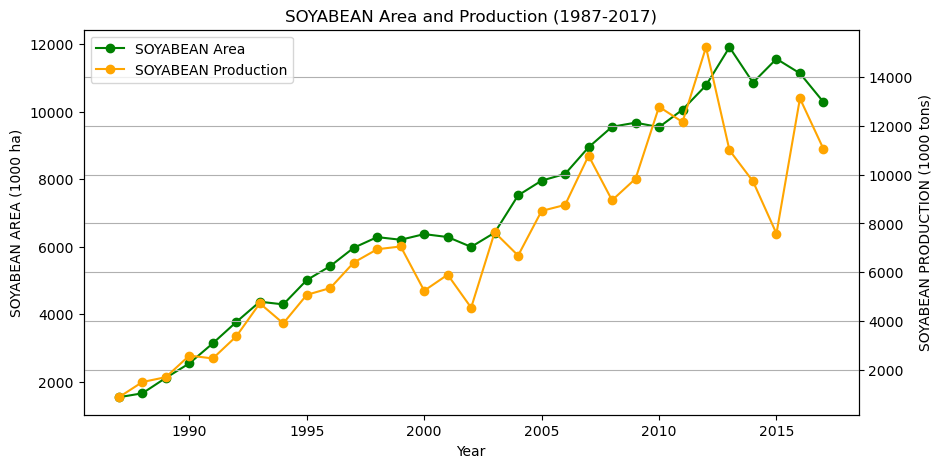

In [72]:
icrisat_crop_line_plot('SOYABEAN', 1987, 2017, plot_yield=False)

# Now we create the crop functions for the hybrid boundary data as well

In [73]:
class HybridCropDataAccessor:
    def __init__(self, dataframe):
        self.df = dataframe
        self.crops = dataframe['ag_hy_crop'].unique()
        self.base_columns = ['name_state', 'state', 'year', 'ag_hy_crop', 'combined', 'change_year', 'geometry']
        
        # Check if we're working with a GeoPandas DataFrame
        self.is_geodf = isinstance(dataframe, gpd.GeoDataFrame)
    
    def _filter_by_years(self, year_min, year_max):
        """Private helper method for year filtering"""
        if year_min is None and year_max is None:
            return self.df
        
        if year_min is None:
            filtered = self.df[self.df['year'] <= year_max]
        elif year_max is None:
            filtered = self.df[self.df['year'] >= year_min]
        else:
            filtered = self.df[(self.df['year'] >= year_min) & (self.df['year'] <= year_max)]
        
        # Ensure we maintain GeoPandas structure
        if self.is_geodf and not isinstance(filtered, gpd.GeoDataFrame):
            filtered = gpd.GeoDataFrame(filtered, geometry='geometry', crs=self.df.crs)
        
        return filtered
    
    def _safe_column_selection(self, dataframe, crop_name, columns):
        """Safely select columns while preserving GeoPandas structure"""
        # Remove duplicates while preserving order
        columns = list(dict.fromkeys(columns))
        
        # Select only columns that exist
        existing_columns = [col for col in columns if col in dataframe.columns]

        if self.is_geodf:
            print('here')
            # For GeoPandas, use .loc to maintain structure
            result = dataframe.loc[:, existing_columns]

            filtered = result[result['ag_hy_crop'] == crop_name]
            
            # Ensure geometry column is set correctly
            if 'geometry' in existing_columns and hasattr(filtered, 'geometry'):
                if not isinstance(filtered, gpd.GeoDataFrame):
                    filtered = gpd.GeoDataFrame(filtered, geometry='geometry', crs=self.df.crs)
                # Make sure geometry column is active
                filtered = filtered.set_geometry('geometry')

            return filtered
        else:
            print('there')
            # Regular pandas DataFrame
            dataframe = dataframe[dataframe['ag_hy_crop'] == crop_name]
            return dataframe[existing_columns]
    
    def _get_crop_data(self, crop_name, column, year_min=None, year_max=None, 
                       additional_columns=None, default=None):
        """Generic method for getting crop data"""
        # Check if crop exists
        if crop_name not in self.crops:
            print(f"Crop '{crop_name}' not found in dataset.")
            return default
        
        # Filter by years
        filtered_df = self._filter_by_years(year_min, year_max)
        
        # Build column list
        columns_to_select = self.base_columns.copy()
        columns_to_select.append(column)
        
        # Add any additional columns requested
        if additional_columns:
            if isinstance(additional_columns, str):
                additional_columns = [additional_columns]
            columns_to_select.extend(additional_columns)
        
        # Use safe column selection to preserve GeoPandas structure
        return self._safe_column_selection(filtered_df, crop_name, columns_to_select)
    
    def get_crop_production(self, crop_name, year_min=None, year_max=None, 
                            additional_columns=None, default=None):
        """Get production data for a specific crop"""
        return self._get_crop_data(crop_name, 'production', year_min, year_max, 
                                   additional_columns, default)
    
    def get_crop_area(self, crop_name, year_min=None, year_max=None, 
                      additional_columns=None, default=None):
        """Get area data for a specific crop"""
        return self._get_crop_data(crop_name, 'area_harvested', year_min, year_max, 
                                   additional_columns, default)
    
    def get_crop_yield(self, crop_name, year_min=None, year_max=None, 
                       additional_columns=None, default=None):
        """Get yield data for a specific crop"""
        return self._get_crop_data(crop_name, 'yield', year_min, year_max, 
                                   additional_columns, default)
    
    def get_all_crop_data(self, crop_name, year_min=None, year_max=None, 
                          additional_columns=None, default=None):
        """Get all available metrics for a crop in one dataframe"""
        if crop_name not in self.crops:
            return default
        
        # Start with base data
        filtered_df = self._filter_by_years(year_min, year_max)
        result_columns = self.base_columns.copy()

        #Add standard columns for this crop
        result_columns.extend(['area_harvested', 'production', 'yield'])
        
        # Add additional columns if requested
        if additional_columns:
            if isinstance(additional_columns, str):
                additional_columns = [additional_columns]
            result_columns.extend(additional_columns)
        
        # Remove duplicates and select existing columns
        print(result_columns)
        result_columns = list(dict.fromkeys(result_columns))
        existing_columns = [col for col in result_columns if col in filtered_df.columns]
        
        return filtered_df[existing_columns]
    
    def get_crop_metrics(self, crop_name):
        """Get all available metrics for a crop"""
        return self.lookup.get(crop_name, {})
    
    def list_crops(self):
        """List all available crops"""
        return list(self.lookup.keys())
    
    def get_available_years(self):
        """Get the range of years available in the dataset"""
        if 'Year' in self.df.columns:
            
            return self.df['year'].min(), self.df['year'].max()
        return None, None

In [74]:
def hybrid_crop_line_plot(df, crop_name, year_min, year_max, plot_yield=False):
    """Plot a line graph for a specific crop's area, production, or yield over a range of years"""

    fig, ax = plt.subplots(figsize=(10, 5))

    #Initialize the HybridCropDataAccessor
    hybrid_accessor = HybridCropDataAccessor(df)

    #Get cotton area and production data
    crop_area = hybrid_accessor.get_crop_area(crop_name, year_min, year_max)
    crop_production = hybrid_accessor.get_crop_production(crop_name, year_min, year_max)

    # Calculate total yearly area
    total_yearly_area = crop_area.groupby('year')['area_harvested'].sum()
    total_yearly_production = crop_production.groupby('year')['production'].sum()

    total_yearly_yield = total_yearly_production / total_yearly_area

    if plot_yield:
        years = np.linspace(year_min, year_max, len(total_yearly_yield))
        ax.plot(years, total_yearly_yield, marker='o', color = 'green',label=crop_name + " Yield")
        ax.set_xlabel('Year')
        ax.set_ylabel('Yield')

        plt.title(f"{crop_name} Yield (%d-%d)" % (year_min, year_max))
        plt.legend()
    
    else:
        # Plotting the area
        years = np.linspace(year_min, year_max, len(total_yearly_area))
        ax.plot(years, total_yearly_area, marker='o', color = 'green',label=crop_name + " Area")
        ax.set_xlabel('Year')
        ax.set_ylabel('Area Harvested (ha)')

        # Plotting the production
        ax2 = ax.twinx()  # Create a second y-axis for production
        ax2.set_ylabel('Production (MT)')
        ax2.plot(years, total_yearly_production, marker='o', color='orange', label=crop_name + " Production")

        lines1, labels1 = ax.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()

        plt.title(f"{crop_name} Area and Production (%d-%d)" % (year_min, year_max))
        plt.legend(lines1 + lines2, labels1 + labels2)
    
    plt.grid()
    plt.show()

In [75]:
hybrid_accessor = HybridCropDataAccessor(merged_hybrid)

# Usage examples
# Just the basics
soybean_area = hybrid_accessor.get_crop_area('Soyabean', 2016, 2023)
soybean_production = hybrid_accessor.get_crop_production('Soyabean', 2016, 2023)

# Get all metrics for a crop at once
all_soybean = hybrid_accessor.get_all_crop_data('Soyabean', 2016, 2023)


here
here
['name_state', 'state', 'year', 'ag_hy_crop', 'combined', 'change_year', 'geometry', 'area_harvested', 'production', 'yield']


<Axes: >

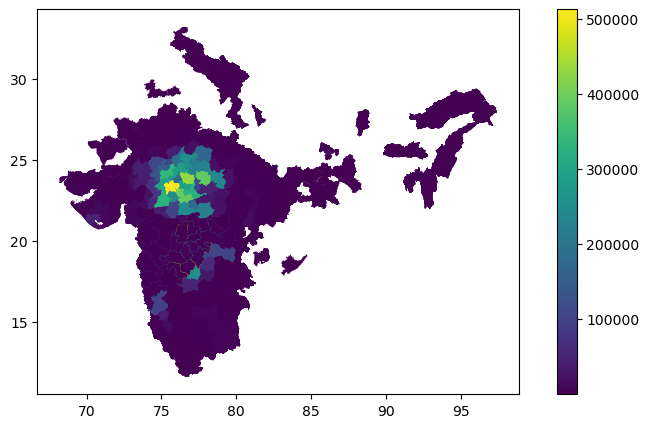

In [76]:
soybean_area.plot(column='area_harvested', legend=True, figsize=(10, 5))

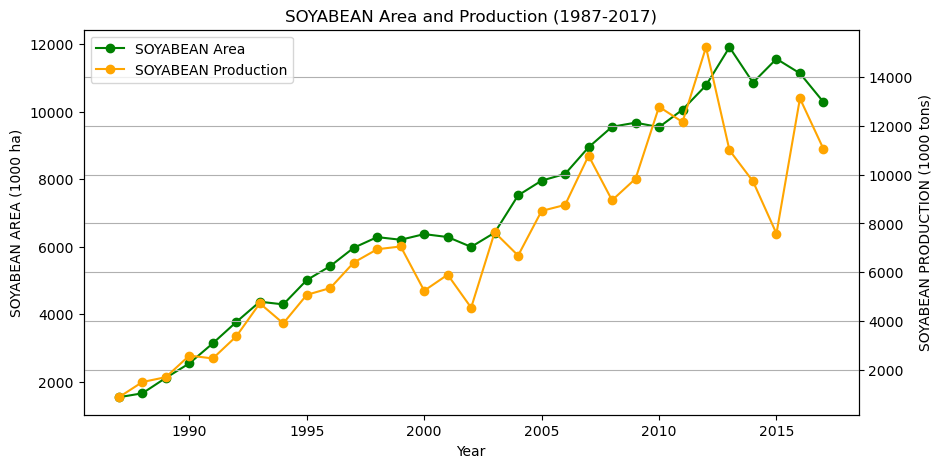

here
here


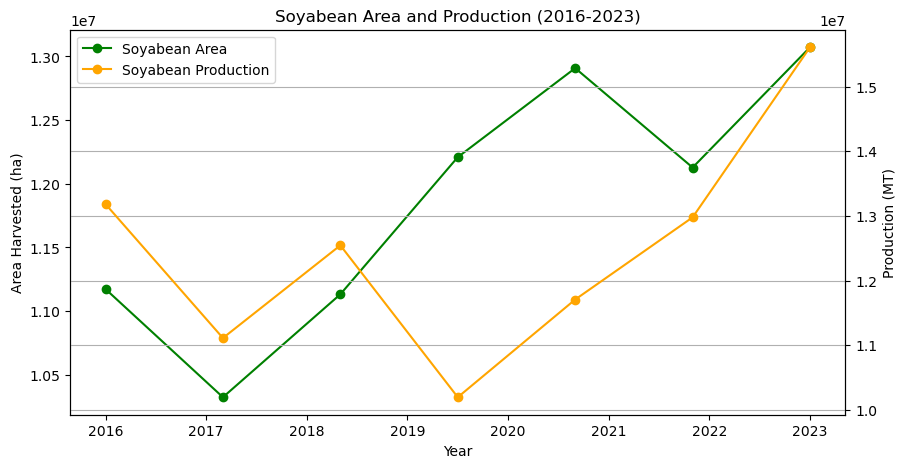

In [77]:
icrisat_crop_line_plot('SOYABEAN', 1987, 2017, plot_yield=False)
hybrid_crop_line_plot(merged_hybrid, 'Soyabean', 2016, 2023, plot_yield=False)

In [78]:
icrisat_area = accessor.get_crop_area('SOYABEAN', 2010, 2017)
hybrid_area = hybrid_accessor.get_crop_area('Soyabean', 2016, 2023)

here


In [79]:
icrisat_data = icrisat_area.groupby('Year')['SOYABEAN AREA (1000 ha)'].sum()
hybrid_data = hybrid_area.groupby('year')['area_harvested'].sum()

In [80]:
hybrid_data

year
2016    11173537.00
2017    10324422.30
2018    11132506.00
2019    12209026.00
2020    12907839.96
2021    12127587.26
2022    13072016.65
Name: area_harvested, dtype: float64

In [81]:
icri_years = np.linspace(2010, 2017, len(icrisat_data))
hybrid_years = np.linspace(2016, 2022, len(hybrid_data))

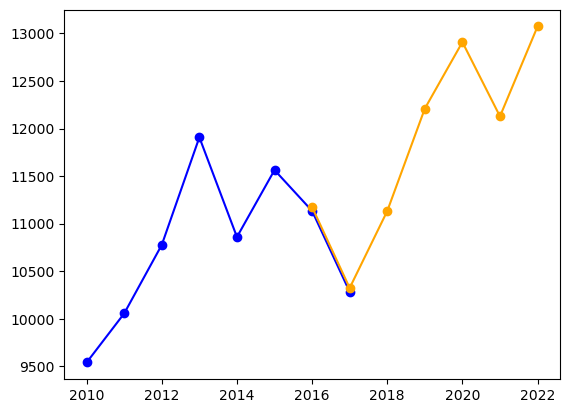

In [82]:
plt.plot(icri_years, icrisat_data, marker='o', label='ICRISAT Soybean Area (1000 ha)', color='blue')
plt.plot(hybrid_years, hybrid_data/1000, marker='o', label='Hybrid Soyabean Area (1000 ha)', color='orange')

# Great! Now we design a function to compare national statistics and yields to what ICRISAT reports in one graph

In [83]:
icri

,NAME_0,ID_0,ISO,ID_1,State Name,ID_2,NAME_2,TYPE_2,ENGTYPE_2,NL_NAME_2,...,JNAME_1,JVARNAME_2,JNAME_1a,JNAME_2,Dist Name,Code,Shape_Leng,Shape_Area,geometry,name
0,India,105,IND,2,Andhra Pradesh,3,Anantapur,District,District,None,...,Andhra Pradesh,"Anantpur, Ananthapur",Andhra Pradesh,Anantapur,Ananthapur,52,11.941762,1.611876,"POLYGON ((77.69 15.17628, 77.69378 15.17347, 7...",Ananthapur
1,India,105,IND,2,Andhra Pradesh,4,Chittoor,District,District,None,...,Andhra Pradesh,Chitoor|Chittor,Andhra Pradesh,Chittoor,Chittoor,54,10.154083,1.266210,"POLYGON ((78.47611 13.9368, 78.48208 13.93007,...",Chittoor
2,India,105,IND,2,Andhra Pradesh,5,Cuddapah,District,District,None,...,Andhra Pradesh,None,Andhra Pradesh,Cuddapah,Kadapa YSR,53,6.682595,1.269949,"POLYGON ((78.94612 15.19465, 78.95062 15.18535...",Kadapa YSR
3,India,105,IND,2,Andhra Pradesh,6,East Godavari,District,District,None,...,Andhra Pradesh,None,Andhra Pradesh,East Godavari,East Godavari,46,8.411279,0.913507,"MULTIPOLYGON (((82.31735 16.57653, 82.31735 16...",East Godavari
4,India,105,IND,2,Andhra Pradesh,7,Guntur,District,District,None,...,Andhra Pradesh,None,Andhra Pradesh,Guntur,Guntur,49,6.955453,0.964803,"MULTIPOLYGON (((80.78291 15.83764, 80.78291 15...",Guntur
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,India,105,IND,36,West Bengal,588,Murshidabad,District,District,None,...,West Bengal,None,West Bengal,Murshidabad,Murshidabad,804,5.073042,0.478267,"MULTIPOLYGON (((88.67597 24.3155, 88.67482 24....",Murshidabad
306,India,105,IND,36,West Bengal,589,Nadia,District,District,None,...,West Bengal,None,West Bengal,Nadia,Nadia,803,5.442187,0.345079,"POLYGON ((88.72438 24.07719, 88.72382 24.07345...",Nadia
307,India,105,IND,36,West Bengal,590,24 Paraganas,District,District,None,...,West Bengal,None,West Bengal,24 Paraganas,24 Parganas,800,40.780417,0.993566,"MULTIPOLYGON (((88.01861 21.57278, 88.01889 21...",24 Parganas
308,India,105,IND,36,West Bengal,591,Puruliya,District,District,None,...,West Bengal,None,West Bengal,Puruliya,Purulia,817,5.147798,0.552180,"POLYGON ((85.88916 23.15176, 85.88641 23.15335...",Purulia


In [84]:
sorted(merged_hybrid['ag_hy_crop'].unique())

['Arecanut',
 'Arhar/Tur',
 'Bajra',
 'Banana',
 'Barley',
 'Black pepper',
 'Cardamom',
 'Cashewnut',
 'Castor seed',
 'Coconut',
 'Coriander',
 'Cotton(lint)',
 'Cowpea(Lobia)',
 'Dry chillies',
 'Garlic',
 'Ginger',
 'Groundnut',
 'Guar seed',
 'Horse-gram',
 'Jowar',
 'Jute',
 'Khesari',
 'Linseed',
 'Maize',
 'Masoor',
 'Mesta',
 'Moong(Green Gram)',
 'Moth',
 'Niger seed',
 'Onion',
 'Other Cereals',
 'Peas & beans (Pulses)',
 'Potato',
 'Ragi',
 'Rapeseed &Mustard',
 'Rice',
 'Safflower',
 'Sannhamp',
 'Sesamum',
 'Small millets',
 'Soyabean',
 'Sugarcane',
 'Sweet potato',
 'Tapioca',
 'Tobacco',
 'Turmeric',
 'Urad',
 'Wheat']

In [85]:
cropkey = pd.read_csv('../../data/cropkey.csv')

In [86]:
def yearly_comparison(crop_name, year, cropkey):
    """
    Compare ICRISAT and Hybrid crop data for a specific crop over a single year.
    
    Parameters:
    crop_name (str): Name of the crop to compare.
    year (int): Year for comparison.
    cropkey (DataFrame): Mapping between crop names and ICRISAT crop names.
    
    Returns:
    tuple: (area_ratio, production_ratio) or (-1, -1) if no data available
    """
    
    # Step 1: Get the ICRISAT crop name
    try:
        icri_crop = cropkey[cropkey['crop'] == crop_name]['icrisat_crop'].values[0]
        print(f"ICRISAT crop for {crop_name}: {icri_crop}")
    except IndexError:
        print(f"No ICRISAT mapping found for {crop_name}")
        return -1, -1
    
    # Step 2: Check if we have a valid ICRISAT crop name
    if not icri_crop or pd.isna(icri_crop):
        print(f"No valid ICRISAT crop found for {crop_name}")
        return -1, -1
    
    # Step 3: Get data using the correct crop names
    # Use icri_crop for ICRISAT accessor, crop_name for hybrid accessor
    icrisat_area = accessor.get_crop_area(icri_crop, year, year)  # Fixed: use icri_crop
    hybrid_area = hybrid_accessor.get_crop_area(crop_name, year, year)
    
    icrisat_production = accessor.get_crop_production(icri_crop, year, year)  # Fixed: use icri_crop
    hybrid_production = hybrid_accessor.get_crop_production(crop_name, year, year)
    
    # Step 4: Debug - check what we got back
    print(f"Debug for {crop_name}:")
    print(f"  ICRISAT area data: {type(icrisat_area)} (None: {icrisat_area is None})")
    print(f"  Hybrid area data: {type(hybrid_area)} (None: {hybrid_area is None})")
    print(f"  ICRISAT production data: {type(icrisat_production)} (None: {icrisat_production is None})")
    print(f"  Hybrid production data: {type(hybrid_production)} (None: {hybrid_production is None})")
    
    # Step 5: Check if we got valid data
    if icrisat_area is None or hybrid_area is None:
        print(f"Missing area data for {crop_name} in {year}")
        return -1, -1
    
    if icrisat_production is None or hybrid_production is None:
        print(f"Missing production data for {crop_name} in {year}")
        return -1, -1
    
    # Step 6: Check if DataFrames are empty
    if icrisat_area.empty or hybrid_area.empty:
        print(f"Empty area data for {crop_name} in {year}")
        return -1, -1
    
    if icrisat_production.empty or hybrid_production.empty:
        print(f"Empty production data for {crop_name} in {year}")
        return -1, -1
    
    try:
        # Step 7: Process the data
        print(f"Processing data for {icri_crop}")
        
        # Check column names before using them
        print(f"ICRISAT area columns: {icrisat_area.columns.tolist()}")
        print(f"Hybrid area columns: {hybrid_area.columns.tolist()}")
        
        # Group by year and sum
        icrisat_area_data = icrisat_area.groupby('Year')[f'{icri_crop} AREA (1000 ha)'].sum()*1000
        hybrid_area_data = hybrid_area.groupby('year')['area_harvested'].sum()
        
        icrisat_prod_data = icrisat_production.groupby('Year')[f'{icri_crop} PRODUCTION (1000 tons)'].sum()*1000
        hybrid_prod_data = hybrid_production.groupby('year')['production'].sum()
        
        # Step 8: Calculate ratios and extract scalar values
        if len(icrisat_area_data) > 0 and len(hybrid_area_data) > 0:
            area_ratio_series = hybrid_area_data / icrisat_area_data
            # Extract the scalar value for the specific year
            if year in area_ratio_series.index:
                area_ratio = area_ratio_series[year]
            else:
                print(f"Year {year} not found in area ratio data for {crop_name}")
                return -1, -1
        else:
            print(f"No area data to calculate ratio for {crop_name}")
            return -1, -1
            
        if len(icrisat_prod_data) > 0 and len(hybrid_prod_data) > 0:
            production_ratio_series = hybrid_prod_data / icrisat_prod_data
            # Extract the scalar value for the specific year
            if year in production_ratio_series.index:
                production_ratio = production_ratio_series[year]
            else:
                print(f"Year {year} not found in production ratio data for {crop_name}")
                return -1, -1
        else:
            print(f"No production data to calculate ratio for {crop_name}")
            return -1, -1
        
        print(f"✅ Calculated ratios - Area: {area_ratio:.3f}, Production: {production_ratio:.3f}")
        return area_ratio, production_ratio
        
    except KeyError as e:
        print(f"Column not found for {crop_name}: {e}")
        return -1, -1
    except Exception as e:
        print(f"Error processing {crop_name}: {e}")
        return -1, -1

In [87]:
# Updated main loop with proper Series handling
area_ratio = {}
production_ratio = {}

print("Starting crop comparison analysis...")
for crop in cropkey['crop'].unique():
    print(f"\n--- Processing {crop} ---")
    area_ratio[crop], production_ratio[crop] = yearly_comparison(crop, 2017, cropkey)
    
    # Check if we got valid ratios (numeric values, not -1)
    if (isinstance(area_ratio[crop], (int, float)) and isinstance(production_ratio[crop], (int, float)) and
        area_ratio[crop] != -1 and production_ratio[crop] != -1):
        try:
            print(f"✅ {crop} - Area Ratio: {area_ratio[crop]:.2f}, Production Ratio: {production_ratio[crop]:.2f}")
        except Exception as e:
            print(f"❌ Error displaying results for {crop}: {e}")
    else:
        print(f"❌ No complete data available for {crop} in 2016")

print("\n--- Summary ---")
successful_crops = [crop for crop in area_ratio.keys() 
                   if isinstance(area_ratio[crop], (int, float)) and area_ratio[crop] != -1]
print(f"Successfully processed: {len(successful_crops)} out of {len(cropkey['crop'].unique())} crops")
print(f"Successful crops: {successful_crops}")

# Display results summary
if successful_crops:
    print("\n--- Results Summary ---")
    for crop in successful_crops:
        print(f"{crop}: Area Ratio = {area_ratio[crop]:.3f}, Production Ratio = {production_ratio[crop]:.3f}")

Starting crop comparison analysis...

--- Processing Arecanut ---
ICRISAT crop for Arecanut: nan
No valid ICRISAT crop found for Arecanut
❌ No complete data available for Arecanut in 2016

--- Processing Arhar/Tur ---
ICRISAT crop for Arhar/Tur: PIGEONPEA
here
here
Debug for Arhar/Tur:
  ICRISAT area data: <class 'geopandas.geodataframe.GeoDataFrame'> (None: False)
  Hybrid area data: <class 'geopandas.geodataframe.GeoDataFrame'> (None: False)
  ICRISAT production data: <class 'geopandas.geodataframe.GeoDataFrame'> (None: False)
  Hybrid production data: <class 'geopandas.geodataframe.GeoDataFrame'> (None: False)
Processing data for PIGEONPEA
ICRISAT area columns: ['State Name', 'Dist_Name', 'Year', 'geometry', 'PIGEONPEA AREA (1000 ha)']
Hybrid area columns: ['name_state', 'year', 'ag_hy_crop', 'combined', 'geometry', 'area_harvested']
✅ Calculated ratios - Area: 0.974, Production: 0.977
✅ Arhar/Tur - Area Ratio: 0.97, Production Ratio: 0.98

--- Processing Bajra ---
ICRISAT crop for 

Great - it seems like just about everything matches with 2-3% except cotton production and sugarcnae production (maybe a units issue?). We are also about 10% lower for Sesamum, 5% lower for Ragi, and a few percent lower for Arhar/Tur. So now we can proceed with the weighting calculation.